In [2]:
import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

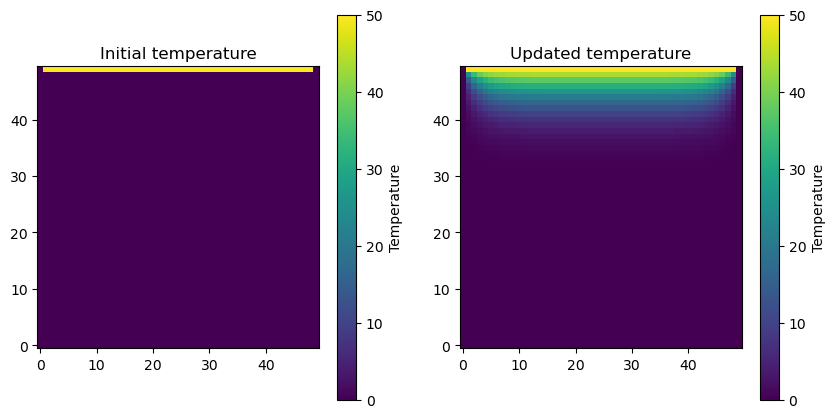

In [15]:
heat_eqn_kernel_src_2D = """
__global__ void heatEqn2D(
            float* u1, 
            float* u0,
            float kappa, 
            float dx,
            float dy,
            float dt,
            unsigned int nx,
            unsigned int ny) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //First cell: new 2D boundaries
    if (i == 0 || i == nx - 1 || j == 0 || j == ny - 1) {
        u1[i + j * nx] = u0[i + j * nx];
    }
    //Internal cells
    else if (i < nx - 1 && j < ny - 1) {
        u1[i + j * nx] = u0[i + j * nx]
                        + kappa * dt / (dx * dx) * (u0[(i - 1) + j * nx] - 2 * u0[i + j * nx] + u0[(i + 1) + j * nx]) 
                        + kappa * dt / (dy * dy) * (u0[i + (j - 1) * nx] - 2 * u0[i + j * nx] + u0[i + (j + 1) * nx]);
    }
}
"""

mod = SourceModule(heat_eqn_kernel_src_2D)
heatEqnGPU_2d = mod.get_function("heatEqn2D")


def heatEquationGPU2D(u0, kappa, dt, dx, dy):
    #We're using single precision in our kernel
    assert(u0.dtype == np.float32)
    
    #We have u0 - initial temperatures. Need to make space for u1
    #Move to GPU!!!
    u1_gpu = cuda.mem_alloc(u0.nbytes)
    
    #Also make u0 on the GPU and upload from CPU
    u0_gpu = cuda.mem_alloc(u0.nbytes)
    cuda.memcpy_htod(u0_gpu, u0)
    
    #Fin
    # out array dimensions in u0 
    ny, nx = u0.shape
    
    #Compute block and grid size:
    block=(256,1,1)
    grid=(int(np.ceil(nx / block[0])), int(np.ceil(ny / block[1])), 1)
    
    heatEqnGPU_2d(u1_gpu, u0_gpu, np.float32(kappa), np.float32(dx), np.float32(dy), np.float32(dt), np.uint32(nx), np.uint32(ny), block=block, grid=grid)
        
    #Swap the new and old temperatures
    u0_gpu, u1_gpu = u1_gpu, u0_gpu
    
    #Download u1, u0 - new temperatures from the GPU to the CPU. 
    u1 = np.empty_like(u0)
    cuda.memcpy_dtoh(u1, u1_gpu)
    cuda.memcpy_dtoh(u0, u0_gpu)
    
    #Return the updated temperatures
    return u1

grid_dim = 50

# Initial condition everywhere inside the grid
grid_temp = 0.0
initial_u = np.empty((grid_dim, grid_dim)).astype(np.float32)
initial_u.fill(grid_temp)

# Boundary conditions 
u_top = 50.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

initial_u[(grid_dim-1):, :] = u_top
initial_u[:, :1] = u_left
initial_u[:1, 1:] = u_bottom
initial_u[:, (grid_dim-1):] = u_right

#Creating two figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First plot settings
im1 = ax1.imshow(initial_u, cmap='viridis', origin='lower', interpolation='none')
ax1.set_title("Initial temperature")
plt.colorbar(im1, ax=ax1, label="Temperature")

# Initializing u1 with initial conditions
u0 = initial_u

# Second plot settings
im2 = ax2.imshow(u0, cmap='viridis', origin='lower', interpolation='none')
ax2.set_title("Updated temperature")
plt.colorbar(im2, ax=ax2, label="Temperature")

# Fuction to create the animation
def update(frame):
    global u0
    u1 = heatEquationGPU2D(u0, kappa=1, dt=0.25, dx=1, dy=1)
    im2.set_array(u1)
    return im2,

ani = animation.FuncAnimation(fig, update, frames=75, blit=True)

# Save the animation as .gif
ani.save('heat_equation_animation.gif', writer='pillow')
plt.show()